In [1]:
from PIL import Image
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../') # add relative path
import open3d as o3d
from plyfile import PlyData, PlyElement

from module.sttr import STTR
from dataset.preprocess import normalization, compute_left_occ_region
from utilities.misc import NestedTensor

/home/neal/anaconda3/envs/pytorch-gpu/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


### Define STTR model

In [2]:
# Default parameters
args = type('', (), {})() # create empty args
args.channel_dim = 128
args.position_encoding='sine1d_rel'
args.num_attn_layers=6
args.nheads=8
args.regression_head='ot'
args.context_adjustment_layer='cal'
args.cal_num_blocks=8
args.cal_feat_dim=16
args.cal_expansion_ratio=4

In [3]:
model = STTR(args).cuda().eval()

In [4]:
# Load the pretrained model
model_file_name = "../kitti_finetuned_model.pth.tar"
checkpoint = torch.load(model_file_name)
pretrained_dict = checkpoint['state_dict']
model.load_state_dict(pretrained_dict, strict=False) # prevent BN parameters from breaking the model loading
print("Pre-trained model successfully loaded.")

Pre-trained model successfully loaded.


### Read image

In [5]:
left = np.array(Image.open('../sample_data/realL.png'))
right = np.array(Image.open('../sample_data/realR.png'))

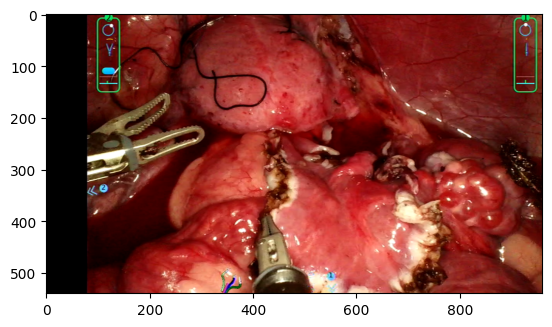

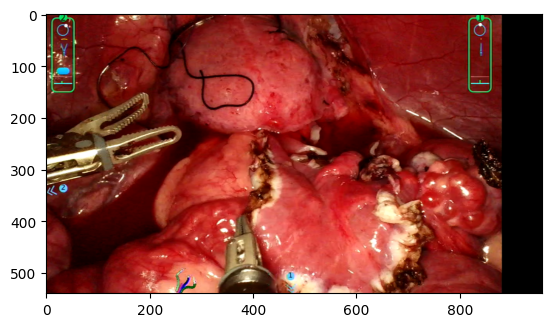

In [6]:
# Visualize image
plt.figure(1)
plt.imshow(left)
plt.figure(2)
plt.imshow(right)

Preprocess data for STTR

In [7]:
# normalize
input_data = {'left': left, 'right':right}
input_data = normalization(**input_data)

In [8]:
# donwsample attention by stride of 3
h, w, _ = left.shape
bs = 1

downsample = 3
col_offset = int(downsample / 2)  # 1
row_offset = int(downsample / 2)
sampled_cols = torch.arange(col_offset, w, downsample)[None,].expand(bs, -1).cuda()
sampled_rows = torch.arange(row_offset, h, downsample)[None,].expand(bs, -1).cuda()

In [9]:
# build NestedTensor
input_data = NestedTensor(input_data['left'].cuda()[None,],input_data['right'].cuda()[None,], sampled_cols=sampled_cols, sampled_rows=sampled_rows)

### Inference

In [10]:
output = model(input_data)

/home/neal/projects/STTR_matching/notebook/../module/pos_encoder.py:54: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


In [41]:
# set disparity of occ area to 0
disp_pred = output['disp_pred'].data.cpu().numpy()[0]
occ_pred = output['occ_pred'].data.cpu().numpy()[0] > 0.5
disp_pred[occ_pred] = 0.0

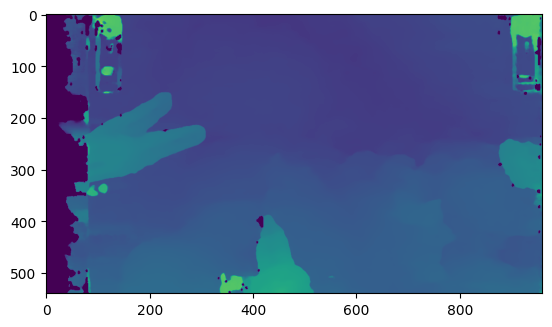

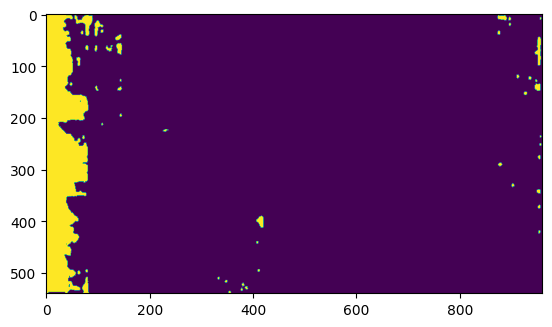

In [42]:
# visualize predicted disparity and occlusion map
plt.figure(4)
plt.imshow(disp_pred)
plt.figure(5)
plt.imshow(occ_pred)

In [40]:
# camera intrinsic
A_cam = np.array([[1156.26, 0.0, 1050.48],
                  [0.0, 1156.26, 560.31],
                  [0.0,     0.0, 1.0]], dtype=np.float32)
b_dis = np.array([-4.04908, -0.00423, -0.06544], dtype=np.float32)
b_dis = np.sqrt(np.sum(b_dis*b_dis))

# calculate XYZ
points_Z0 = A_cam[0,0]*b_dis/(disp_pred*2.0)
u_mesh = np.linspace(1,disp_pred.shape[1],disp_pred.shape[1])[None,:]
u_mesh = np.concatenate([u_mesh for i in range(disp_pred.shape[0])],axis=0)
points_X0 = points_Z0*(u_mesh*2.0-A_cam[0,2])/A_cam[0,0]
v_mesh = np.linspace(1,disp_pred.shape[0],disp_pred.shape[0])[:,None]
v_mesh = np.concatenate([v_mesh for i in range(disp_pred.shape[1])],axis=1)
points_Y0 = points_Z0*(v_mesh*2.0-A_cam[1,2])/A_cam[1,1]
points = np.concatenate((points_X0.flatten()[:,None],points_Y0.flatten()[:,None],points_Z0.flatten()[:,None]), axis=1)

points_mask = (points[:,2]>0) & (points[:,2]<150)
points = points[points_mask,:]

# visualize
pcd = o3d.geometry.PointCloud()
pcd.points=o3d.utility.Vector3dVector(points)
o3d.visualization.draw_geometries([pcd])

# save ply
def write_ply(points, filename):
    points = [(points[i,0], points[i,1], points[i,2]) for i in range(points.shape[0])]
    vertex = np.array(points, dtype=[('x', 'f4'), ('y', 'f4'),('z', 'f4')])
    el = PlyElement.describe(vertex, 'vertex', comments=['vertices'])
    PlyData([el], text=True).write(filename)
write_ply(points, 'scene.ply')

/tmp/ipykernel_6120/3977913624.py:9: RuntimeWarning: divide by zero encountered in true_divide
  points_Z0 = A_cam[0,0]*b_dis/(disp_pred*2.0)


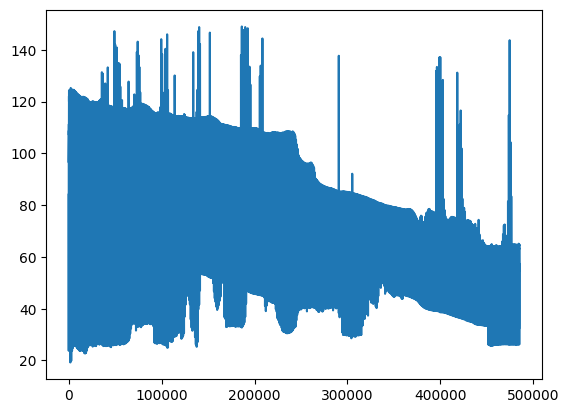

In [39]:
# 绘图
plt.plot(np.arange(points.shape[0]),points[:,2])

plt.show()
